In [1]:
import numpy as np 
import pandas as pd 
import h5py
import pingouin as pg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
# functions 
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files


def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    for t in range(n_trials):
        
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)


def find_candidate_states(indata, n_classes, temporal_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > (1 / n_classes) * 2)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array


def save_data_to_h5(directory, filename, datasets, dataset_names):
    """
    Saves multiple datasets to an HDF5 file, overwriting existing datasets.

    Args:
        directory (str): The directory where the file should be saved.
        filename (str): The name of the HDF5 file.
        datasets (list): A list of datasets to save.
        dataset_names (list): A list of names to assign to the datasets.
    """

    full_path = os.path.join(directory, filename)

    with h5py.File(full_path, 'a') as f:  # Open in append mode
        for dataset, dataset_name in zip(datasets, dataset_names):
            try:
                del f[dataset_name]  # Attempt to delete existing dataset
            except KeyError:
                pass  # Ignore if dataset doesn't exist
            f.create_dataset(dataset_name, data=dataset)  # Recreate dataset

In [3]:
file_path = 'C:/Users/thome/Documents/PYTHON/Self-Control/data2/D20231229_Rec09.h5'
list_hdf5_data(file_path)

Datasets in 'C:/Users/thome/Documents/PYTHON/Self-Control/data2/D20231229_Rec09.h5':
CdN_FR
CdN_channels
CdN_locations
CdN_mean_wf
CdN_u_names
CdN_zFR
OFC_FR
OFC_channels
OFC_locations
OFC_mean_wf
OFC_u_names
OFC_zFR
bhv
ts


In [4]:
# load relevant data

OFC_fr = pull_from_h5(file_path, 'OFC_zFR')
CdN_fr = pull_from_h5(file_path, 'CdN_zFR')
ts = pull_from_h5(file_path, 'ts')
bhv = pd.read_hdf(file_path,'bhv')

OFC_wf = pull_from_h5(file_path, 'OFC_mean_wf')
OFC_locs = pull_from_h5(file_path, 'OFC_locations')

CdN_wf = pull_from_h5(file_path, 'CdN_mean_wf')
CdN_locs = pull_from_h5(file_path, 'CdN_locations')

print(OFC_wf.shape[0], 'units in OFC')
print(CdN_wf.shape[0], 'units in CdN')

179 units in OFC
270 units in CdN


In [5]:
# find the value-encoding units
OFC_val_ix = np.zeros(shape=(OFC_wf.shape[0], ))
CdN_val_ix = np.zeros(shape=(CdN_wf.shape[0], ))

choice_on = np.argmin(np.abs(ts - 0))
choice_off = np.argmin(np.abs(ts - 500))

OFC_choice_FR = np.nanmean(OFC_fr[:,choice_on:choice_off,:], axis=1)
CdN_choice_FR = np.nanmean(CdN_fr[:,choice_on:choice_off,:], axis=1)

anova_df = pd.DataFrame()
anova_df['val'] = bhv['ch_val']
anova_df['state'] = bhv['state']


# first, do OFC
for ofc_ix in range(OFC_wf.shape[0]):
    
    anova_df['OFC_fr'] = OFC_choice_FR[:,ofc_ix]
    anova_tbl = pg.anova(data = anova_df, dv='OFC_fr', between=['val', 'state'])
    
    if  (anova_tbl['p-unc'].values[2] < .01):
        OFC_val_ix[ofc_ix] = True
        

# now, caudate
for cdn_ix in range(CdN_wf.shape[0]):
    
    anova_df['CdN_fr'] = CdN_choice_FR[:,cdn_ix]
    anova_tbl = pg.anova(data = anova_df, dv='CdN_fr', between=['val', 'state'])
    
    if (anova_tbl['p-unc'].values[0] < .01) | (anova_tbl['p-unc'].values[2] < .01):
        CdN_val_ix[cdn_ix] = True
    


In [6]:
np.sum(OFC_val_ix)

36.0

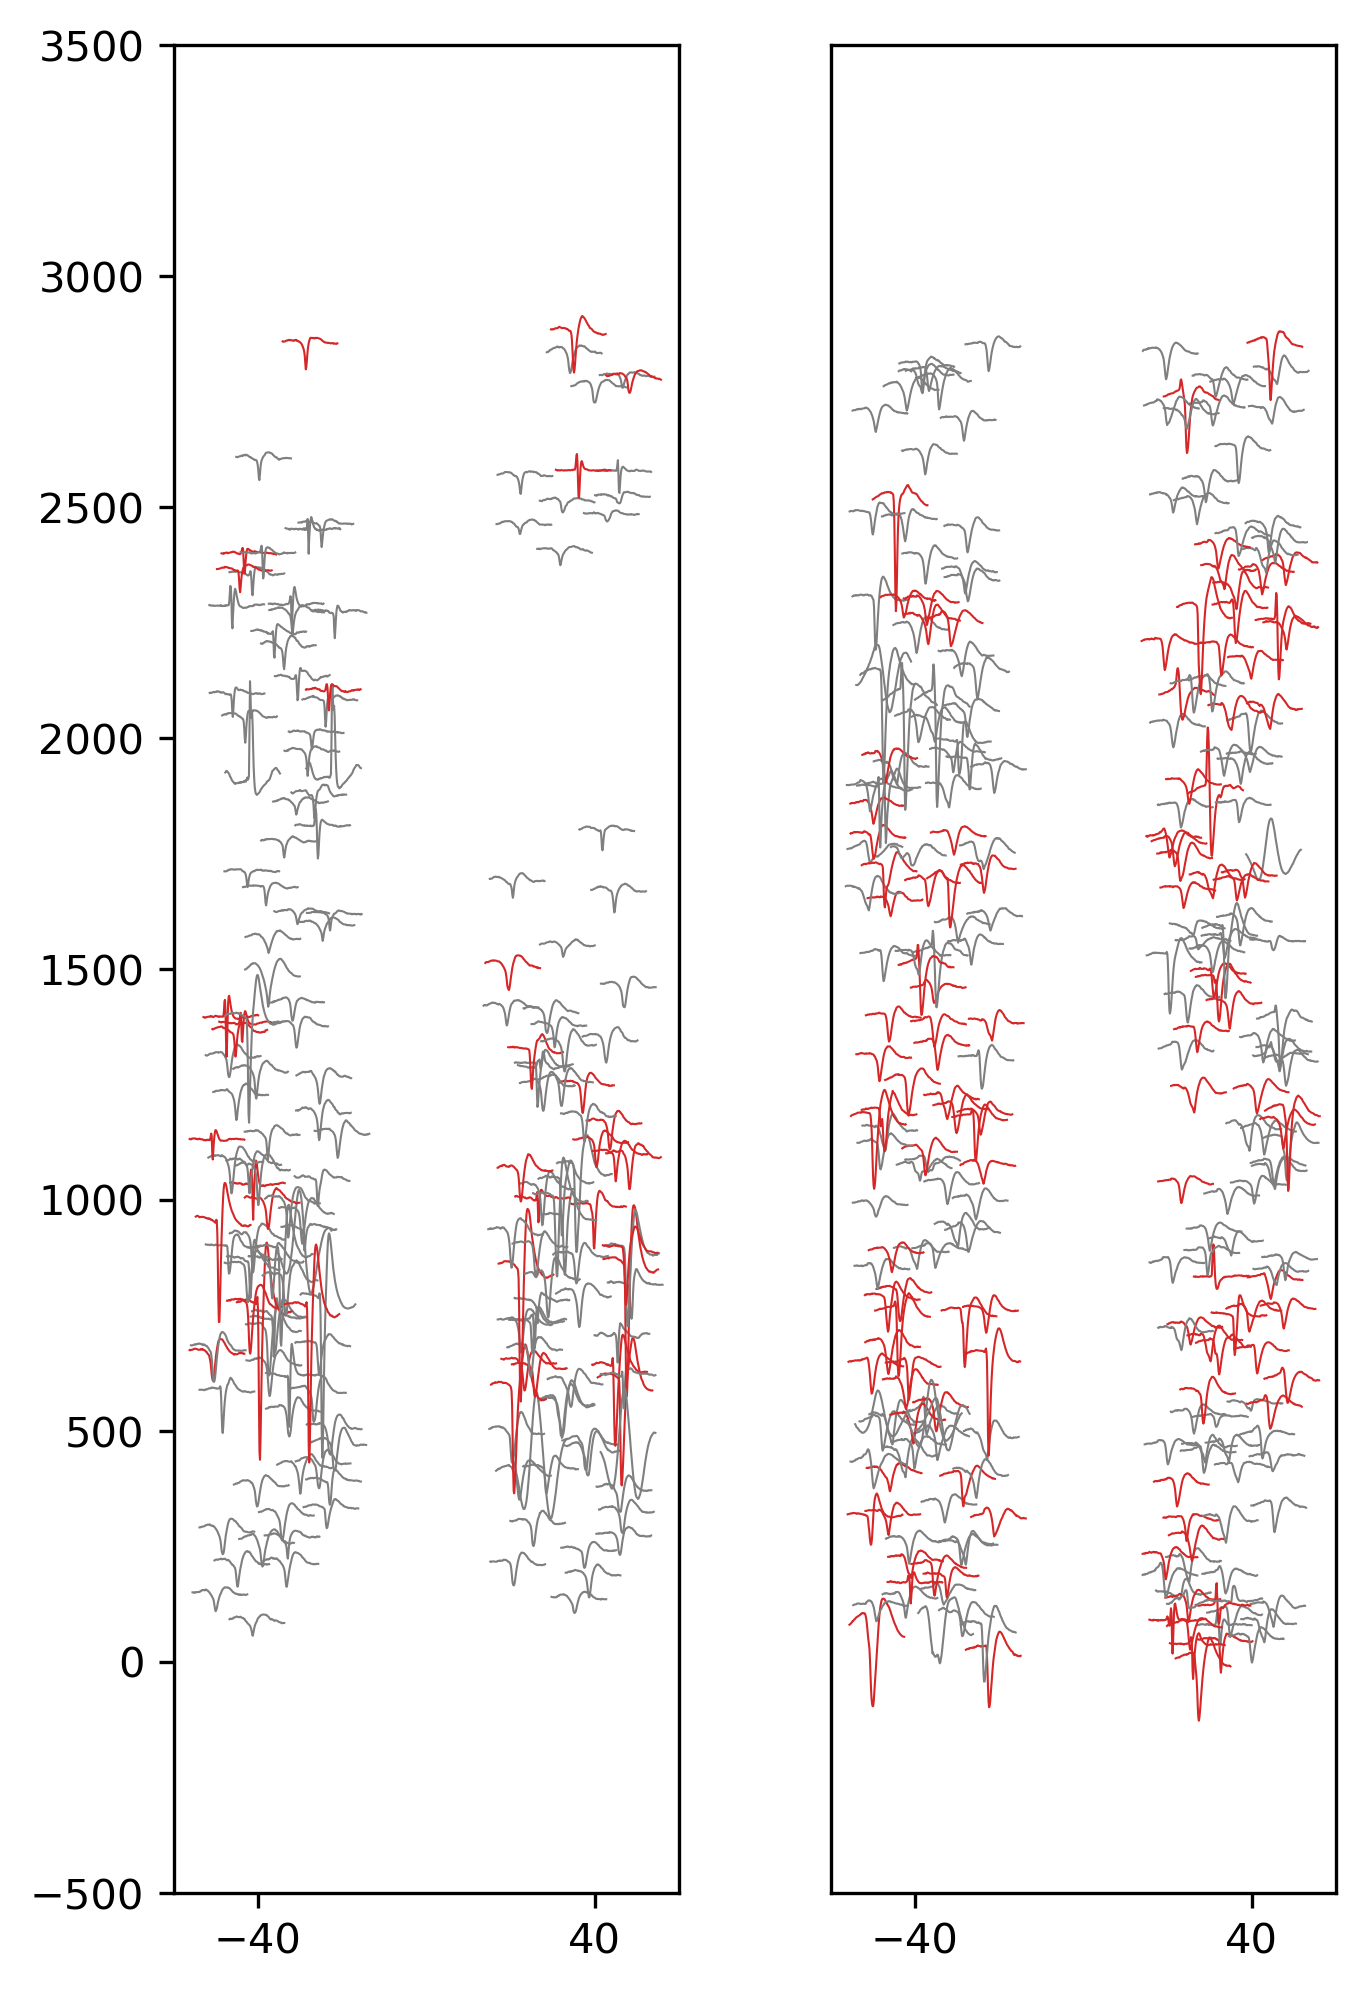

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(5, 8), dpi=300)

lw = .5
ylim=(-500, 3500)
xlim=(-60, 60)
xticks = (-40, 40)
y_scale = 5

wave_x = ((np.arange(OFC_wf.shape[1], )) - np.median(np.arange(OFC_wf.shape[1]))) / 8

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase the width and height spaces between subplots

# first plot OFC waveforms
for i in range(OFC_locs.shape[0]):
    
    if OFC_val_ix[i]:
        col = 'tab:red'
    else:
        col = 'tab:gray'
    ax[0].plot(wave_x + OFC_locs[i,0], (OFC_wf[i,:]*y_scale) + OFC_locs[i, 1] + 20,
                   linewidth = lw, color=col)

    ax[0].set_xlim(xlim)
    ax[0].set_xticks(xticks)
    ax[0].set_ylim(ylim)
    
# first plot OFC waveforms
for i in range(CdN_locs.shape[0]):
    
    if CdN_val_ix[i]:
        col = 'tab:red'
    else:
        col = 'tab:gray'
    
    ax[1].plot(wave_x + CdN_locs[i,0], (CdN_wf[i,:]*y_scale) + CdN_locs[i, 1] + 20, linewidth = lw, color=col)
    ax[1].set_xlim(xlim)
    ax[1].set_xticks(xticks)
    ax[1].set_ylim(ylim)
    ax[1].tick_params(axis='both', which='both', top=False, right=False, left=False, labelleft=False)

#fig.savefig('probe_visualization_bad_column.svg', format='svg')


In [8]:
np.median(np.arange(105))

52.0